# Logistic Regression (applied to dummy data)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

az.style.use('arviz-darkgrid')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load raw data and plot

In [2]:
# read .csv file into Dataframe
data = pd.read_csv('../../data/test/dummy_data.csv')
data

,1200,1300,1400,1500,1600,1700,code,label
0,6.859681,9.472035,15.243682,8.041220,1.359436,0.569499,1,Arabica
1,6.309441,8.401346,15.041552,8.278361,1.028300,1.463044,1,Arabica
2,5.746870,8.223710,16.166272,7.937323,1.125077,1.658064,1,Arabica
3,6.884220,8.235310,16.066599,7.607464,1.831370,0.867443,1,Arabica
4,5.746478,8.615229,15.325160,7.945671,2.605825,1.126482,1,Arabica
5,5.276155,8.619932,8.136409,7.454639,2.973493,1.923625,2,Robusta
6,6.138655,9.805064,9.425262,8.270688,1.467806,0.466879,2,Robusta
7,6.072105,8.877384,8.498315,8.260295,1.528403,0.216872,2,Robusta
8,6.200951,9.619839,9.501848,8.088760,2.424705,1.398675,2,Robusta
9,6.823931,8.042763,9.400266,8.787564,1.583661,0.777459,2,Robusta


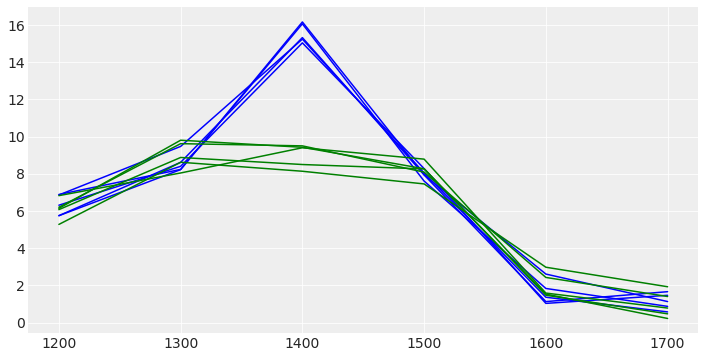

In [3]:
# header data = x-values
cols = data.columns.to_list()
x_val = np.array(cols[:-2], dtype='float32')

# plot all data in 1 figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes()

for i in range(len(data)):
    y_val = data.values[i]
    if y_val[-2] == 1:
        col = 'blue'
    else:
        col = 'green'
    plt.plot(x_val, y_val[:-2], '-', color=col);

In [4]:
# extract X data from dataframe
X = data.iloc[:,:-2].to_numpy()
X.shape

(10, 6)

In [5]:
# extract Y data from dataframe
Y = data.iloc[:,-2].to_numpy()
Y.shape

(10,)

In [6]:
# add a column of ones to X
Xn = np.append(np.ones((X.shape[0],1)), X, axis=1)
Xn.shape

(10, 7)

## Model definition

In [7]:
with pm.Model() as model_mlr:
    beta = pm.Normal('beta', mu=0, sd=0.5, shape=Xn.shape[1])
    epsilon = pm.HalfNormal('epsilon', 10)
    
    mu = pm.math.dot(Xn, beta)

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=Y)

    trace_mlr = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta]
Sampling 2 chains: 100%|██████████| 5000/5000 [01:01<00:00, 81.53draws/s] 
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


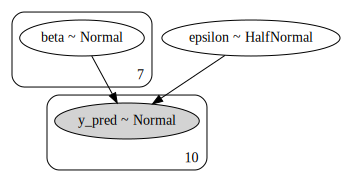

In [8]:
pm.model_to_graphviz(model_mlr)

In [9]:
az.summary(trace_mlr)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta[0],0.113,0.504,-0.846,1.058,0.012,0.010,1918.0,1164.0,1930.0,1154.0,1.0
beta[1],0.081,0.156,-0.221,0.365,0.004,0.003,1557.0,1388.0,1552.0,1960.0,1.0
beta[2],0.074,0.098,-0.105,0.267,0.002,0.002,1892.0,1551.0,1932.0,1633.0,1.0
beta[3],-0.137,0.024,-0.184,-0.095,0.000,0.000,2379.0,2352.0,2434.0,2186.0,1.0
beta[4],0.214,0.146,-0.048,0.511,0.004,0.003,1629.0,1519.0,1651.0,1796.0,1.0
beta[5],0.060,0.120,-0.185,0.282,0.003,0.002,2211.0,1247.0,2182.0,1382.0,1.0
beta[6],0.082,0.146,-0.192,0.357,0.003,0.003,2241.0,1226.0,2208.0,1801.0,1.0
epsilon,0.191,0.090,0.085,0.339,0.003,0.002,881.0,881.0,665.0,1258.0,1.0


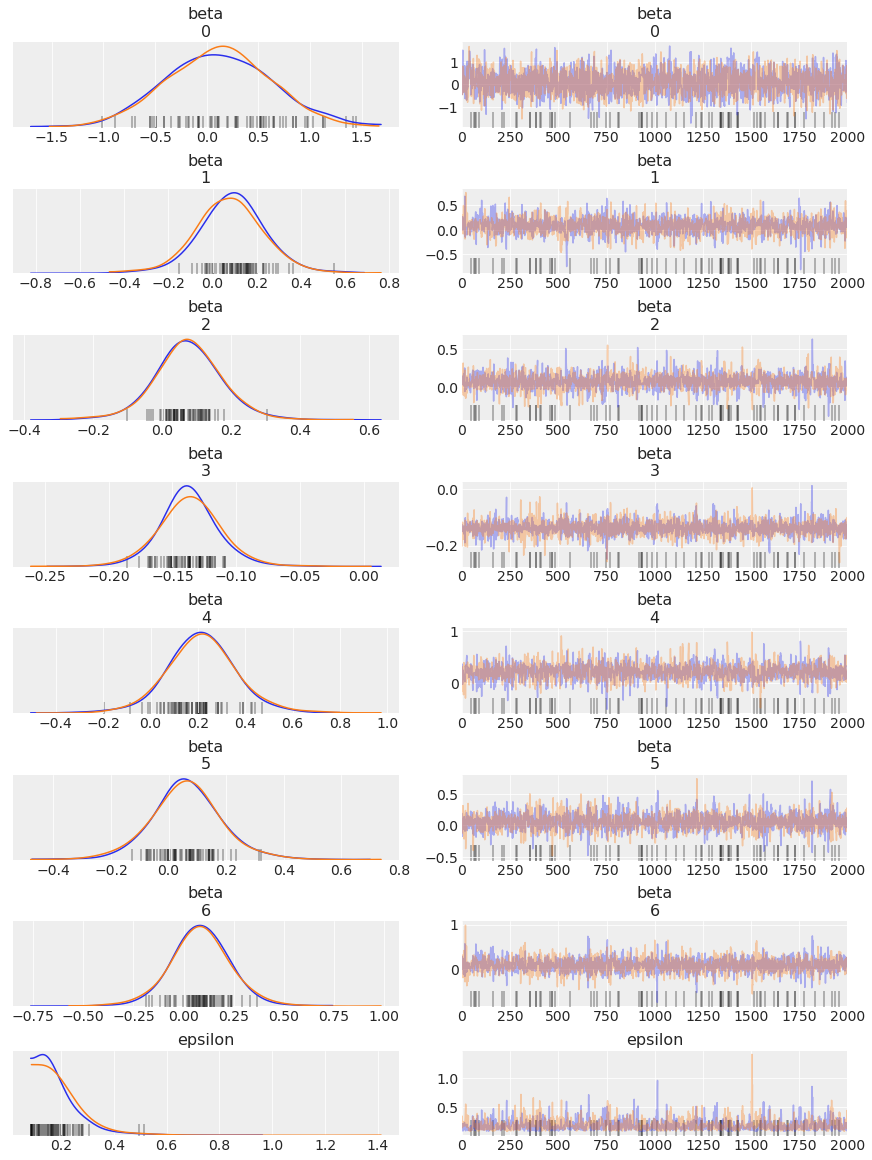

In [10]:
az.plot_trace(trace_mlr);

In [17]:
#az.plot_posterior(trace_mlr);

In [18]:
#az.plot_autocorr(trace_mlr);

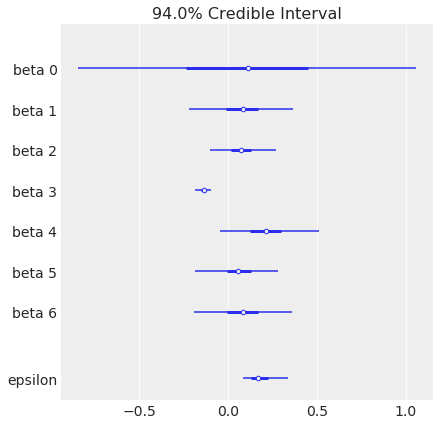

In [12]:
az.plot_forest(trace_mlr, combined=True);

In [13]:
ppc = pm.sample_posterior_predictive(trace_mlr, samples=100, model=model_mlr)

100%|██████████| 100/100 [00:00<00:00, 598.14it/s]


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


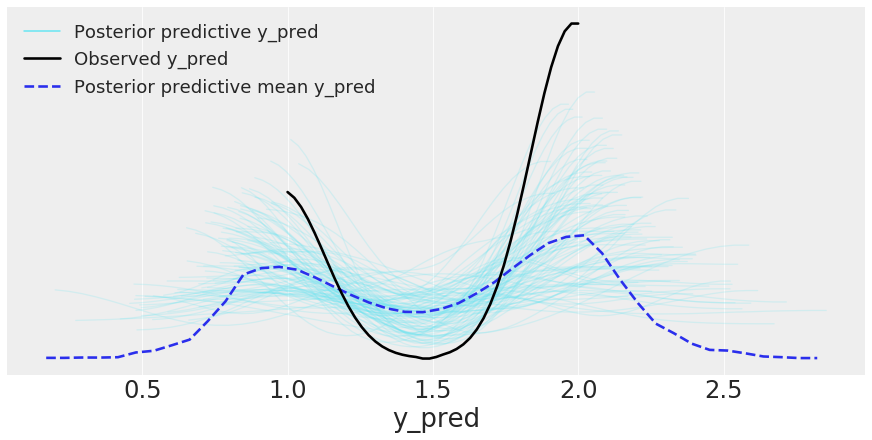

In [14]:
data_ppc = az.from_pymc3(trace=trace_mlr, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)